In [1]:
%cd ..

/kaggle/working


In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../experiments/ensemble_001"):
    cfg = compose(config_name="config.yaml", overrides=["exp=base"])
    print(OmegaConf.to_yaml(cfg))

debug: false
seed: 42
dir:
  data_dir: /kaggle/working/input/atmaCup16_Dataset
  output_dir: /kaggle/working/output
  exp_dir: /kaggle/working/output/exp
  cand_unsupervised_dir: /kaggle/working/output/cand_unsupervised
  cand_supervised_dir: /kaggle/working/output/cand_supervised
  datasets_dir: /kaggle/working/output/datasets
exp:
  other_dirs:
  - output/exp/008_split/base
  first_dirs:
  - output/exp/008_split/first



In [3]:
import logging
import os
import pickle
import sys
import time
from pathlib import Path

import hydra
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from tqdm.auto import tqdm

import utils
import wandb
from utils.load import load_label_data, load_log_data, load_session_data, load_yad_data
from utils.logger import get_logger
from utils.metrics import calculate_metrics

In [4]:
train_log_df = load_log_data(Path(cfg.dir.data_dir), "train")
test_log_df = load_log_data(Path(cfg.dir.data_dir), "test")
len(train_log_df["session_id"].unique()), len(test_log_df["session_id"].unique())

(288698, 174700)

288698 174700


<Axes: xlabel='counts', ylabel='counts_right'>

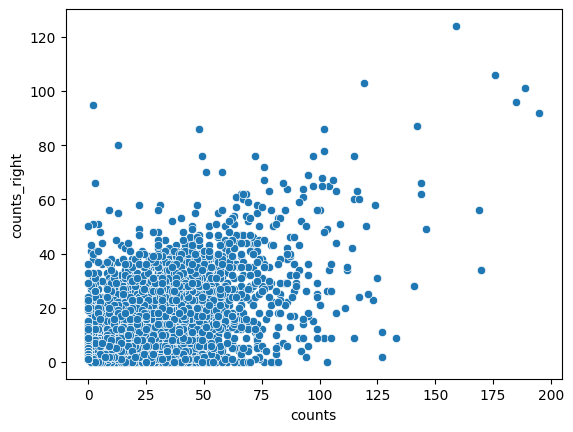

In [25]:
# session内に出現したyad_idの集合がtrain,testでどれだけ一致するのかを確認
import seaborn as sns

train_session_unique_df = (
    train_log_df.drop("seq_no")
    .unique(["session_id", "yad_no"])
    .sort(by=["session_id", "yad_no"])
    .with_columns(pl.col("yad_no").cast(str))
    .group_by("session_id")
    .agg(pl.col("yad_no"))
    .with_columns(pl.col("yad_no").list.join(","))
)
test_session_unique_df = (
    test_log_df.drop("seq_no")
    .unique(["session_id", "yad_no"])
    .sort(by=["session_id", "yad_no"])
    .with_columns(pl.col("yad_no").cast(str))
    .group_by("session_id")
    .agg(pl.col("yad_no"))
    .with_columns(pl.col("yad_no").list.join(","))
)
print(len(train_session_unique_df), len(test_session_unique_df))
count_df = (
    train_session_unique_df["yad_no"]
    .value_counts()
    .join(test_session_unique_df["yad_no"].value_counts(), on="yad_no", how="outer")
    .fill_null(0)
)


sns.scatterplot(data=count_df, x="counts", y="counts_right")

185386 113940


<Axes: xlabel='counts', ylabel='counts_right'>

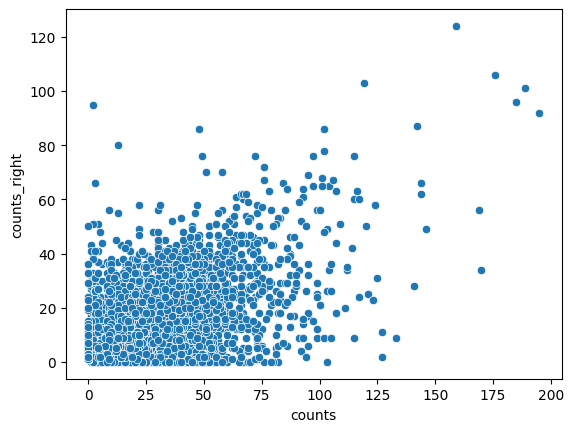

In [26]:
# 長さ１のsession内に出現したyad_idの集合がtrain,testでどれだけ一致するのかを確認
import seaborn as sns

train_session_unique_df = (
    train_log_df.filter(pl.col("seq_no").max().over("session_id") == 0)
    .drop("seq_no")
    .unique(["session_id", "yad_no"])
    .sort(by=["session_id", "yad_no"])
    .with_columns(pl.col("yad_no").cast(str))
    .group_by("session_id")
    .agg(pl.col("yad_no"))
    .with_columns(pl.col("yad_no").list.join(","))
)
test_session_unique_df = (
    test_log_df.filter(pl.col("seq_no").max().over("session_id") == 0)
    .drop("seq_no")
    .unique(["session_id", "yad_no"])
    .sort(by=["session_id", "yad_no"])
    .with_columns(pl.col("yad_no").cast(str))
    .group_by("session_id")
    .agg(pl.col("yad_no"))
    .with_columns(pl.col("yad_no").list.join(","))
)
print(len(train_session_unique_df), len(test_session_unique_df))

count_df = (
    train_session_unique_df["yad_no"]
    .value_counts()
    .join(test_session_unique_df["yad_no"].value_counts(), on="yad_no", how="outer")
    .fill_null(0)
)

sns.scatterplot(data=count_df, x="counts", y="counts_right")